In [1]:
import cv2
import numpy as np
from enum import Enum
import colorsys
import moviepy.editor as mpe
import moviepy
from typing import *
import random
import pandas as pd
import json
import torch
from icecream import ic

In [2]:
import IPython
def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [3]:
exp_1_1_data = pd.read_csv('./resources/experiment_1_1_1.csv')
orange_rgbs = exp_1_1_data.loc[lambda r:r['ans'] == 0, :]

In [4]:
NUM_POSITIONS = 16  
IMG_SIZE = 224
ROW_LEN = NUM_POSITIONS**0.5
RADIUS = int(IMG_SIZE / (2 * ROW_LEN)) # 28
assert ROW_LEN == 4
assert RADIUS == 28
COLOR_ID_TO_LABEL = {0: 'orange', 1: 'brown', 2: 'both', 3: 'neither'}

class ColorOption:
    def __init__(self, circle_rgb, bg_rgb):
        self.circle_rgb = circle_rgb
        self.bg_rgb = bg_rgb
    
    
def generate_sample():
    pos = random.randrange(0, NUM_POSITIONS)
    color = random_color()
    circle_img = circle_img(pos, color.circle_rgb)
  

def random_orange() -> ColorOption:
    # TODO replace with function.
    orange_rgbs = exp_1_1_data.loc[lambda r:r['ans'] == 0, :]
    idx = random.randrange(0, orange_rgbs.shape[0])
    circle_rgb  = json.loads(orange_rgbs.iloc[idx]['circle_rgb'])
    bg_rgb = json.loads(orange_rgbs.iloc[idx]['bg_rgb'])
    circle_rgb = np.array(circle_rgb)*255
    bg_rgb = np.array(bg_rgb)*255
    return ColorOption(circle_rgb, bg_rgb)

    
def random_brown() -> ColorOption:
    # TODO replace with function.
    brown_rgbs = exp_1_1_data.loc[lambda r:r['ans'] == 1, :]
    idx = random.randrange(0, brown_rgbs.shape[0])
    circle_rgb  = json.loads(brown_rgbs.iloc[idx]['circle_rgb'])
    bg_rgb = json.loads(brown_rgbs.iloc[idx]['bg_rgb'])
    circle_rgb = np.array(circle_rgb)*255
    bg_rgb = np.array(bg_rgb)*255
    return ColorOption(circle_rgb, bg_rgb)


def random_color() -> ColorOption:
    fctns = [random_orange, random_brown]
    idx = random.randrange(0, 2)
    label = "orange" if idx == 0 else "brown"
    f = fctns[idx]
    return f(), label


def coords(position_idx : int) -> Tuple[int, int]:
    """Calculates the (y, x) coordinates of a position index.
    
    Origin is top left.
    """
    if not 0 <= position_idx < NUM_POSITIONS:
        raise Exception(f'Position index must be within 0 and {NUM_POSITIONS}. '
                        'Got: {position_idx}')
    row = position_idx // ROW_LEN
    col = position_idx % ROW_LEN
    y = int(RADIUS * (row * 2 + 1))
    x = int(RADIUS * (col * 2 + 1))
    return (y, x)
     
    
def to_cv2_coords(numpy_coords):
    return (numpy_coords[1], numpy_coords[0])
    
    
def circle_img(position_idx, circle_color, bg_color):
    img = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
    img[:] = bg_color
    center = to_cv2_coords(coords(position_idx))
    img = cv2.circle(img, center, RADIUS, circle_color, thickness=-1, lineType=cv2.LINE_AA)
    return img


def create_samples(num_samples):
    frames = []
    labels = []
    for n in range(num_samples):
        color, label = random_color()
        pos = random.randrange(0, NUM_POSITIONS)
        frame = circle_img(pos, color.circle_rgb, color.bg_rgb)
        frames.append(frame)
        labels.append(label)
    return frames, labels
    

In [5]:
def demo_data():
    FPS = 2
    #frames = [circle_img(p, (255, 255, 255), (50, 20, 20)) for p in range(NUM_POSITIONS)]
    #labels = ['WB-0']*len(frames)
    frames, labels = create_samples(30)
    x_clip = mpe.ImageSequenceClip(frames, fps=2)
    y_clip = mpe.TextClip('WB-0', font='DejaVu-Sans')

    class FrameText(mpe.VideoClip):
        def __init__(self, text, fps):
            def make_frame(f):
               return mpe.TextClip(text[int(f)], font='DejaVu-Sans', color='white').get_frame(f)
            self.duration = 1.0 * len(text) / fps
            mpe.VideoClip.__init__(self, make_frame=make_frame, duration=self.duration)

    y_clip =   FrameText(labels, FPS)
    label_clip = mpe.CompositeVideoClip([mpe.ImageClip(np.zeros((IMG_SIZE, IMG_SIZE, 3)), duration=5), y_clip])
    comp_clip = mpe.clips_array([[y_clip],[x_clip]])
    return comp_clip
clip = demo_data() 
clip.ipython_display()

t:  20%|██        | 6/30 [00:00<00:00, 50.43it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


ic| (label, circle_rgb, bg_rgb): ('neither',
                                  [0.0919521144198634, 0.06222013694077136, 0.02023531774301041],
                                  [0.8176636490942133, 0.8176636490942133, 0.8176636490942133])


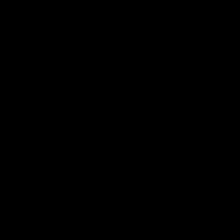

In [6]:
class ColorDotDataset(torch.utils.data.Dataset):
    "Colored circles on colored background, a dataset."
    
    def __init__(self, labelled_colors):
        """Generate dataset from an array of (label, circle_rgb, bg_rgb) tuples.
        """
        #self._labelled_colors = 
        self._labelled_colors = labelled_colors
        
    def __len__(self):
        return len(self._labelled_colors) * NUM_POSITIONS
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        color_idx = idx // NUM_POSITIONS
        pos = idx % NUM_POSITIONS
        label, circle_rgb, bg_rgb = self._labelled_colors[color_idx]
        ic((label, circle_rgb, bg_rgb))
        return {'image': circle_img(pos, circle_rgb, bg_rgb), 'label': label}
    
    
def train_test_val_split(labelled_colors, split_ratio=[6, 1, 1]):
    divisions = np.sum(np.array(split_ratio))
    num_per_division = len(labelled_colors) // divisions
    remainder = len(labelled_colors) % divisions
    num_train = num_per_division * split_ratio[0] + remainder
    num_test = num_per_division * split_ratio[1]
    num_val = num_per_division * split_ratio[2]
    
    train_ds = ColorDotDataset(labelled_colors[0: num_train])
    test_ds = ColorDotDataset(labelled_colors[num_train: num_train + num_test])
    val_ds = ColorDotDataset(labelled_colors[num_train + num_test:])
    return (train_ds, test_ds, val_ds)


def load_labelled_colors(csv_path):
    # TOD: how to properly filter and map pandas data?
    table = pd.read_csv('./resources/experiment_1_1_1.csv')
    include_labels = {'orange', 'brown', 'neither'}
    ans = []
    #table[0] = table[0].apply(lambda x : COLOR_ID_TO_LABEL[x])
    #filtered = table[table['ans'] in include_labels]
    for idx, row in table.iterrows():
        label = COLOR_ID_TO_LABEL[row['ans']]
        if not label in include_labels:
            continue
        circle_rgb = json.loads(row['circle_rgb'])
        bg_rgb = json.loads(row['bg_rgb'])
        ans.append((label, circle_rgb, bg_rgb))
    return ans


def load_datasets(csv_path):
    labelled_colors = load_labelled_colors(csv_path)
    datasets = train_test_val_split(labelled_colors)
    return datasets
    
    
    
    
def test_dataset():
    train, test, val = load_datasets('./resources/experiment_1_1_1.csv')
    imshow(test[200]['image'])
   
test_dataset()